In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import geopandas as gpd
import matplotlib.ticker as ticker

/tmp/ipykernel_47/1974193342.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  toll['Result'] = toll['Deaths'] / toll['Confirmed']
/tmp/ipykernel_47/1974193342.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


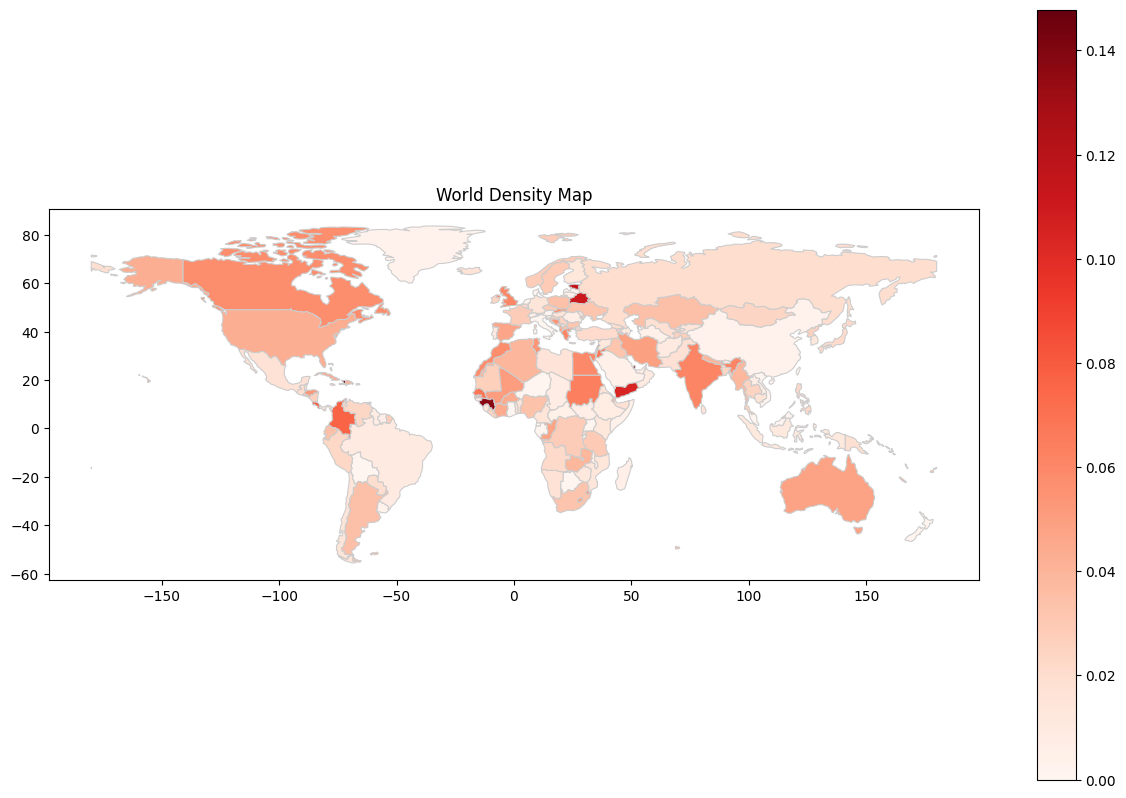

In [5]:
country = pd.read_csv("/kaggle/input/covid-dataset/country_wise_latest.csv")

toll = country[['Country/Region','Confirmed', 'Deaths', 'Recovered']]
toll['Result'] = toll['Deaths'] / toll['Confirmed']
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[world['name'] != 'Antarctica']
world = world.merge(toll[['Result']], left_index=True, right_index=True)


fig, ax = plt.subplots(figsize=(15, 10))
ax.set_title('World Density Map')
world.plot(column='Result', cmap='Reds', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
plt.show()

I created a map that would just show the density of deaths per confirmed as you can see that they is not really a pattern, which we can conclude that every country followed their own protocols based on their capabilities. It was an event that we we learned from.

How would this look in the scatterplot? Would it be easier to see?

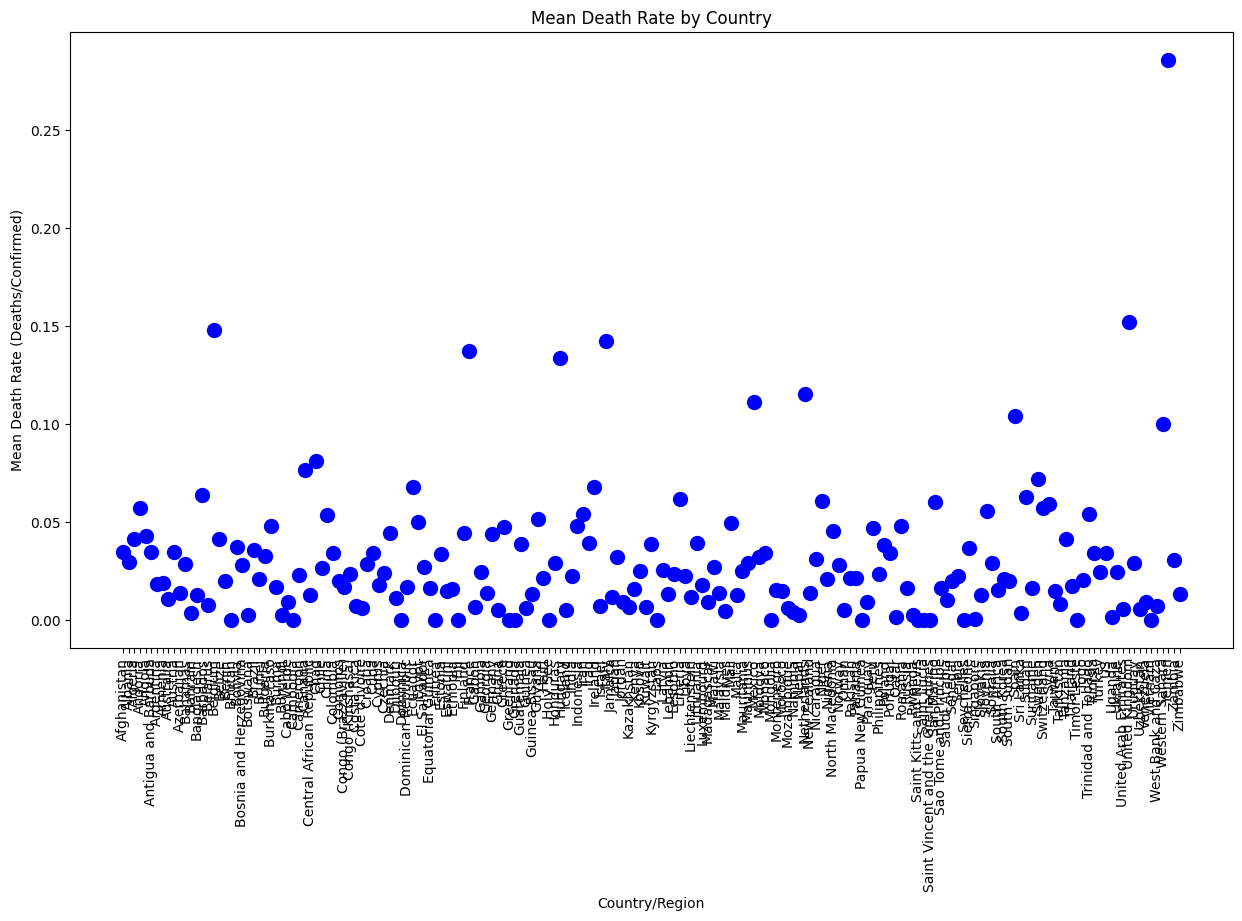

In [50]:
mean_death_rate = toll.groupby('Country/Region')['Result'].mean().reset_index()


plt.figure(figsize=(15, 8))
plt.scatter(mean_death_rate['Country/Region'], mean_death_rate['Result'], s=100, color='blue')
plt.title('Mean Death Rate by Country')
plt.xlabel('Country/Region')
plt.ylabel('Mean Death Rate (Deaths/Confirmed)')
plt.xticks(rotation=90)  
plt.show()

As we can it pretty similar death rates for most countries, we would see some few outliers implying that that COVID-19 did heavily affect them. 

What are those countries? 

Let's graph them! By just comparing the top 10 highest rates of deaths.

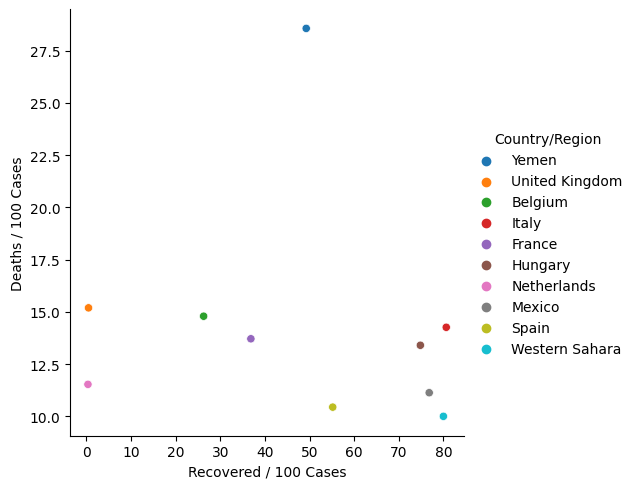

In [20]:
country['Deaths / Confirmed'] = country['Deaths'] / country['Confirmed']
sortedcountries = country.sort_values(by='Deaths / Confirmed', ascending=False)
top10 = sortedcountries.head(10)

sns.relplot(data=top10, x='Recovered / 100 Cases', y='Deaths / 100 Cases', hue='Country/Region', kind='scatter')
plt.show()

These top 10 Countries, suprise me I would suggest a country to be in Asian.  We can see that COVID was spreading before we even had a clue. 

Lets analyze a daily trend maybe we can see a pattern that could suggest that COVID was spreading as a specific pattern.

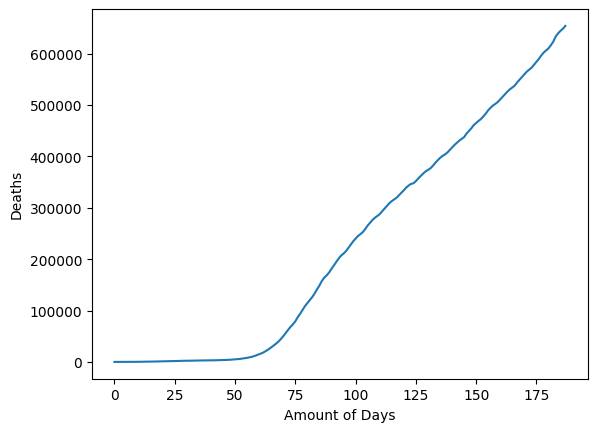

In [22]:
daily = pd.read_csv('/kaggle/input/covid-dataset/day_wise.csv')
daily['date'] = pd.to_datetime(daily['Date'])
x = range(len(daily['date']))
plt.plot(x, daily['Deaths'])
plt.xlabel('Amount of Days')
plt.ylabel('Deaths')
plt.show()

The dataset had 175 days and as we can see after the day 75 the amounts of death increased pretty heavily, it was increasing by an estimate of 100,000 people per 25 days. Which could suggest that after 2 months of COVID spread had the most impact in our communities.

Maybe we can sum all our variables of our data and maybe we can see more patterns. 

We want to compare the sum , of Confirmed, Deaths, Recovered, Active, New cases, New deaths, New recovered.

In [ ]:
a = daily['Confirmed'].sum()
b = daily['Deaths'].sum()
c = daily['Recovered'].sum()
d = daily['Active'].sum()
e = daily['New cases'].sum()
f = daily['New deaths'].sum()
g = daily['New recovered'].sum()
variables = ['Confirmed', 'Deaths', 'Recovered', 'Active', 'New cases', 'New deaths', 'New recovered']
values = [a, b , c , d , e , f ,g]

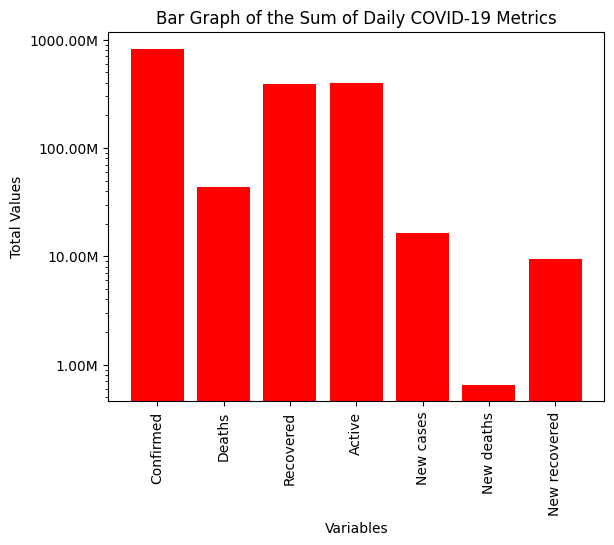

In [24]:
plt.bar(variables, values, color='red')
plt.yscale('log')
plt.xticks(rotation='vertical')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1e6:.2f}M'))
plt.xlabel('Variables')
plt.ylabel('Total Values')
plt.title('Bar Graph of the Sum of Daily COVID-19 Metrics')
plt.show()

As we can see in our bargraph that that Death and Recorvered compare to each other it the difference or ratio could be compared with the new deaths and new recovered. 

What does this suggest?

It can suggest that throughtout time we got better at handling COVID cases and saving lifes!

Let's graph it!

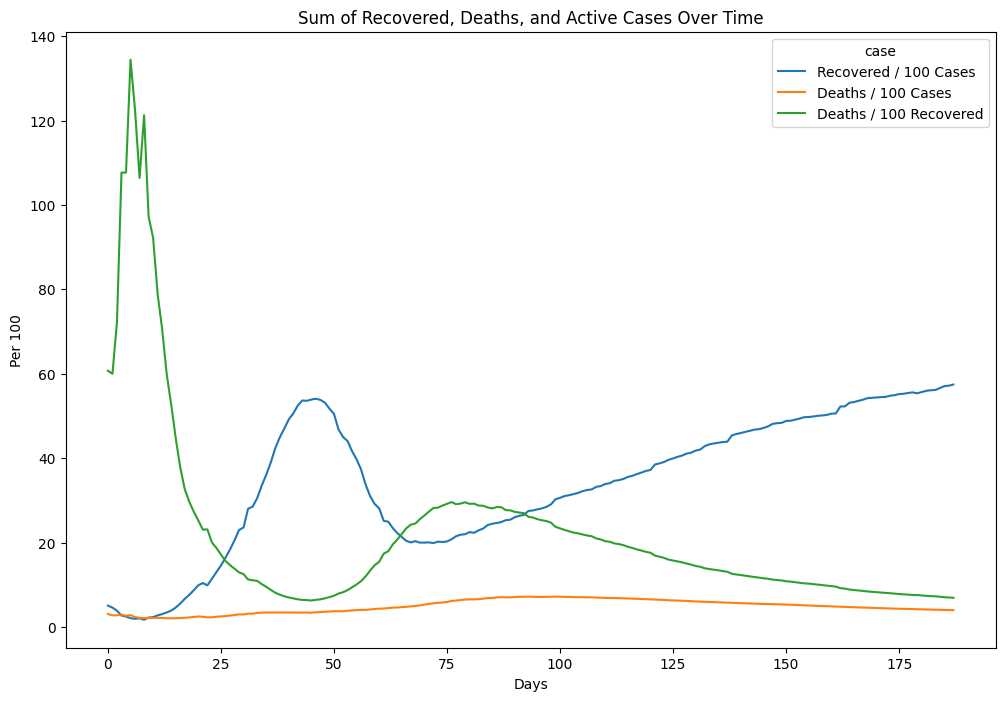

In [40]:
daily['date'] = pd.to_datetime(daily['Date'])
x = range(len(daily['date']))
daily['index'] = x

graph = daily.groupby('index')[['Deaths / 100 Cases', 'Recovered / 100 Cases', 'Deaths / 100 Recovered']].sum().reset_index()
graph = graph.melt(id_vars="index", value_vars=['Recovered / 100 Cases', 'Deaths / 100 Cases', 'Deaths / 100 Recovered'],
                   var_name='case', value_name='count')

plt.figure(figsize=(12, 8))
sns.lineplot(x='index', y='count', hue='case', data=graph)
plt.title('Sum of Recovered, Deaths, and Active Cases Over Time')
plt.xlabel('Days')
plt.ylabel('Per 100')
plt.show()

We can see patterns in graph, deaths and recovered go aganist each other when deaths decrease recovered increase. Which is a reasonable pattern to see!

Let's talk about the United States!

In [25]:
usa = pd.read_csv('/kaggle/input/covid-dataset/usa_county_wise.csv')

Let's group everything by State.

In [26]:
usa['Total_Confirmed'] = usa.groupby('Province_State')['Confirmed'].transform('sum')
usa['Total_Deaths'] = usa.groupby('Province_State')['Deaths'].transform('sum')

There is territories that are not states, lets remove them! 
SORRY!

Made it into a dataframe!

In [47]:
usa['Confirmed'] = usa['Confirmed'].astype(int)
usa['Deaths'] = usa['Deaths'].astype(int)

usa_grouped = usa.groupby('Province_State', as_index=False).agg({'Confirmed': 'sum', 'Deaths': 'sum'})
states_to_remove = ['American Samoa', 'Diamond Princess', 'District of Columbia', 'Grand Princess','Guam','Northern Mariana Islands','Virgin Islands']
usa_grouped = usa_grouped[~usa_grouped['Province_State'].isin(states_to_remove)]
print(usa_grouped)

    Province_State  Confirmed   Deaths
0          Alabama    2880805    73446
1           Alaska      85686     3999
3          Arizona    5272303   128478
4         Arkansas    1415802    19171
5       California   17618695   481757
6         Colorado    2860699   142506
7      Connecticut    4239220   374346
8         Delaware     962637    37494
11         Florida   12657802   292541
12         Georgia    6859759   222262
15          Hawaii      92930     2003
16           Idaho     565768    12980
17        Illinois   11900637   541672
18         Indiana    3792618   200183
19            Iowa    2231209    57245
20          Kansas    1188588    38359
21        Kentucky    1253913    46743
22       Louisiana    5383429   285084
23           Maine     257125     9256
24        Maryland    5393907   254828
25   Massachusetts    9874030   666157
26        Michigan    6690544   576093
27       Minnesota    2637428   107860
28     Mississippi    2124940    81848
29        Missouri    184

Let's see our data! Let's see if we can see a pattern!


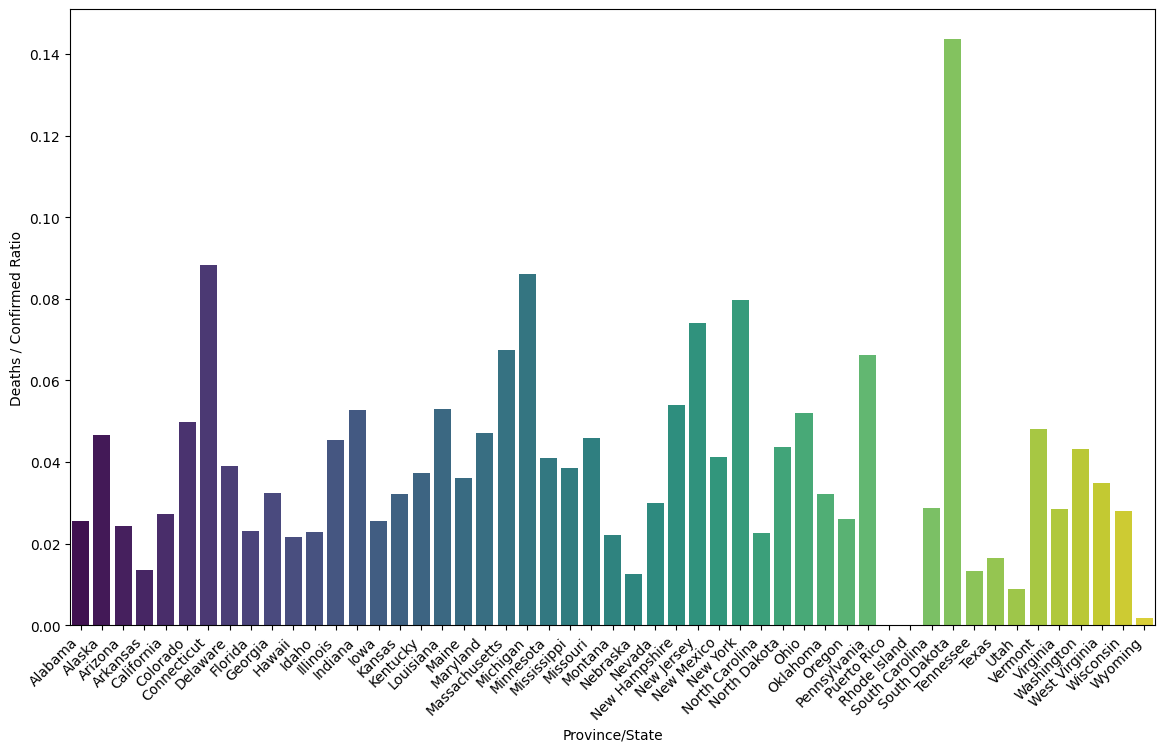

In [48]:
usa_grouped['Deaths / Confirmed'] = usa_grouped['Deaths'] / usa_grouped['Confirmed']

plt.figure(figsize=(14, 8))
sns.barplot(data=usa_grouped, x='Province_State', y='Deaths / Confirmed', palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Province/State')
plt.ylabel('Deaths / Confirmed Ratio')
plt.show()

As we can see in our bar graph some states were relatively low and some were relatively high, which is surprising. 

Now, lets talk globably.

In [32]:
worldwide = pd.read_csv('/kaggle/input/covid-dataset/worldometer_data.csv')

Let's group them by continent. Maybe we can compare each continent.

In [33]:
grouped_data = worldwide.groupby('Continent')[['TotalDeaths', 'TotalCases','TotalRecovered']].sum().reset_index()
editworldwide = pd.DataFrame(grouped_data)
print(editworldwide)

           Continent  TotalDeaths  TotalCases  TotalRecovered
0             Africa      22114.0     1011867        693620.0
1               Asia     100627.0     4689794       3508170.0
2  Australia/Oceania        281.0       21735         12620.0
3             Europe     205232.0     2982576       1587302.0
4      North America     229855.0     5919209       3151678.0
5      South America     154885.0     4543273       3116150.0


Let's graph them and see their total death, total cases, and total recovered.

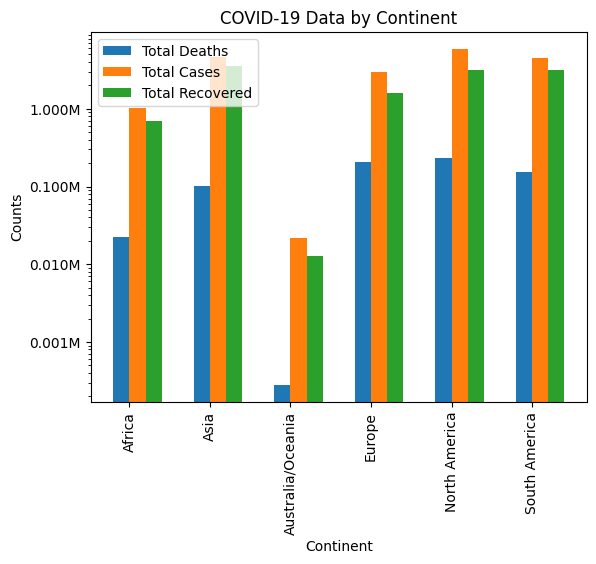

In [36]:
X_axis = np.arange(len(grouped_data['Continent']))
bar_width = 0.2

plt.bar(X_axis - 0.2, height=grouped_data['TotalDeaths'], label='Total Deaths', width=bar_width, align='edge')
plt.bar(X_axis, height=grouped_data['TotalCases'], label='Total Cases', width=bar_width, align='edge')
plt.bar(X_axis + 0.2, height=grouped_data['TotalRecovered'], label='Total Recovered', width=bar_width, align='edge')

plt.yscale('log')
plt.xticks(rotation='vertical')
## plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1e4:.0f}10K'))
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1e6:.3f}M'))



plt.legend()
plt.title('COVID-19 Data by Continent')
plt.xlabel('Continent')
plt.ylabel('Counts')

# Set x-axis ticks to be the actual continent names
plt.xticks(X_axis, grouped_data['Continent'])

plt.show()

I will say that my data might not be normally distributed but, its hard to see, let's keep in mind that the scale of y-axis might be hard to understand.

Maybe we can see it better in a graph.

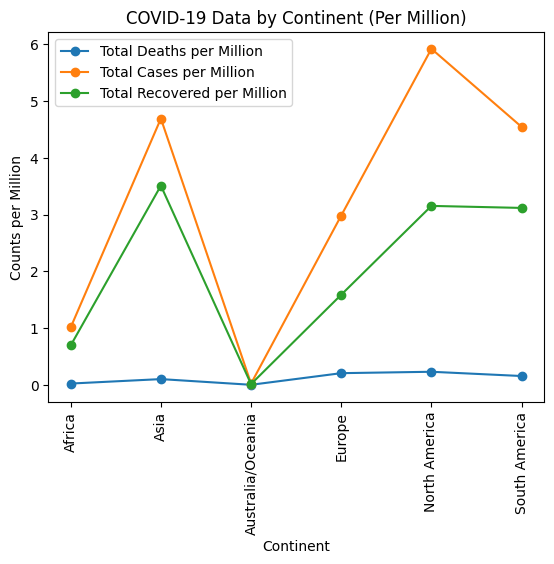

In [38]:
grouped_dataa = worldwide.groupby('Continent')[['TotalDeaths', 'TotalCases', 'TotalRecovered']].sum().reset_index()

X_axis = np.arange(len(grouped_dataa['Continent']))

total_deaths_per_million = grouped_dataa['TotalDeaths'] / 1e6
total_cases_per_million = grouped_dataa['TotalCases'] / 1e6
total_recovered_per_million = grouped_dataa['TotalRecovered'] / 1e6

plt.plot(X_axis, total_deaths_per_million, label='Total Deaths per Million', marker='o')
plt.plot(X_axis, total_cases_per_million, label='Total Cases per Million', marker='o')
plt.plot(X_axis, total_recovered_per_million, label='Total Recovered per Million', marker='o')

plt.xticks(X_axis, grouped_dataa['Continent'], rotation='vertical')

# Custom formatter for y-axis ticks in millions (M)
plt.legend()
plt.title('COVID-19 Data by Continent (Per Million)')
plt.xlabel('Continent')
plt.ylabel('Counts per Million')

plt.show()

We scaled the y-axis by million, which can be easier to see.

We can see the deaths on every continent was relatively low. We can that North America and Asia was really high their cases. In Asia, we can recovered and cases ratio was pretty high.